In [9]:
!cp /content/drive/My\ Drive/yolo.h5 /content/data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [40]:
import os
import time
import cv2
import numpy as np
from model.yolo_model import YOLO

In [41]:
def process_image(img):
    """Resize, reduce and expand image.

    # Argument:
        img: original image.

    # Returns
        image: ndarray(64, 64, 3), processed image.
    """
    image = cv2.resize(img, (416, 416),
                       interpolation=cv2.INTER_CUBIC)
    image = np.array(image, dtype='float32')
    image /= 255.
    image = np.expand_dims(image, axis=0)

    return image

In [42]:
def get_classes(file):
    """Get classes name.

    # Argument:
        file: classes name for database.

    # Returns
        class_names: List, classes name.

    """
    with open(file) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]

    return class_names

In [57]:
def draw(image, boxes, scores, classes, all_classes):
    """Draw the boxes on the image.

    # Argument:
        image: original image.
        boxes: ndarray, boxes of objects.
        classes: ndarray, classes of objects.
        scores: ndarray, scores of objects.
        all_classes: all classes name.
    """
    for box, score, cl in zip(boxes, scores, classes):
        x, y, w, h = box

        top = max(0, np.floor(x + 0.5).astype(int))
        left = max(0, np.floor(y + 0.5).astype(int))
        right = min(image.shape[1], np.floor(x + w + 0.5).astype(int))
        bottom = min(image.shape[0], np.floor(y + h + 0.5).astype(int))
        #print(classes, all_classes[cl], cl)
        arr =[0,67]
        if cl not in arr:
          continue
        cv2.rectangle(image, (top, left), (right, bottom), (255, 0, 0), 2)
        cv2.putText(image, '{0} {1:.2f}'.format(all_classes[cl], score),
                    (top, left - 6),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 0, 255), 1,
                    cv2.LINE_AA)

        print('class: {0}, score: {1:.2f}'.format(all_classes[cl], score))
        print('box coordinate x,y,w,h: {0}'.format(box))

    print()

In [58]:
def detect_image(image, yolo, all_classes):
    """Use yolo v3 to detect images.

    # Argument:
        image: original image.
        yolo: YOLO, yolo model.
        all_classes: all classes name.

    # Returns:
        image: processed image.
    """
    pimage = process_image(image)

    start = time.time()
    boxes, classes, scores = yolo.predict(pimage, image.shape)
    end = time.time()

    print('time: {0:.2f}s'.format(end - start))

    if boxes is not None:
        draw(image, boxes, scores, classes, all_classes)

    return image

In [15]:
def detect_video(video, yolo, all_classes):
    """Use yolo v3 to detect video.

    # Argument:
        video: video file.
        yolo: YOLO, yolo model.
        all_classes: all classes name.
    """
    video_path = os.path.join("videos", "test", video)
    camera = cv2.VideoCapture(video_path)
    cv2.namedWindow("detection", cv2.WINDOW_AUTOSIZE)

    # Prepare for saving the detected video
    sz = (int(camera.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(camera.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fourcc = cv2.VideoWriter_fourcc(*'mpeg')

    
    vout = cv2.VideoWriter()
    vout.open(os.path.join("videos", "res", video), fourcc, 20, sz, True)

    while True:
        res, frame = camera.read()

        if not res:
            break

        image = detect_image(frame, yolo, all_classes)
        cv2.imshow("detection", image)

        # Save the video frame by frame
        vout.write(image)

        if cv2.waitKey(110) & 0xff == 27:
                break

    vout.release()
    camera.release()
    

In [59]:
yolo = YOLO(0.6, 0.5)
file = '/content/data/coco_classes.txt'
all_classes = get_classes(file)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Detecting Images

In [60]:
f = 'test2.jpg'
path = 'images/'+f
image = cv2.imread(path)
image = detect_image(image, yolo, all_classes)
cv2.imwrite('images/res/' + f, image)

time: 4.90s
class: person, score: 0.96
box coordinate x,y,w,h: [-15.78176349 275.46075633 473.79640818 326.02260476]
class: cell phone, score: 1.00
box coordinate x,y,w,h: [199.37579155 127.09592175 220.92596248 434.31920755]



True

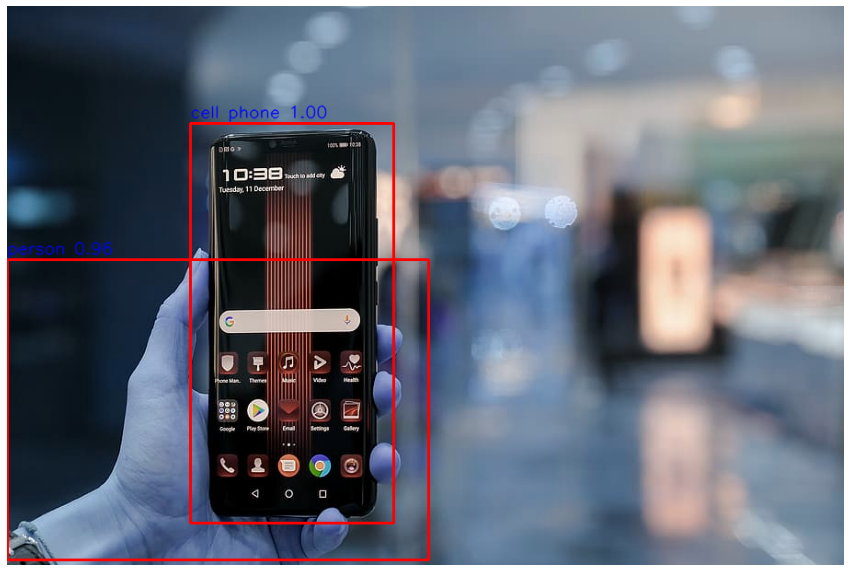

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(image)
plt.show()

In [62]:
f = 'person.jpg'
path = 'images/'+f
image = cv2.imread(path)
image = detect_image(image, yolo, all_classes)
cv2.imwrite('images/res/' + f, image)

time: 1.48s
class: person, score: 1.00
box coordinate x,y,w,h: [187.64701843  83.23578691  91.80776596 306.35434055]



True

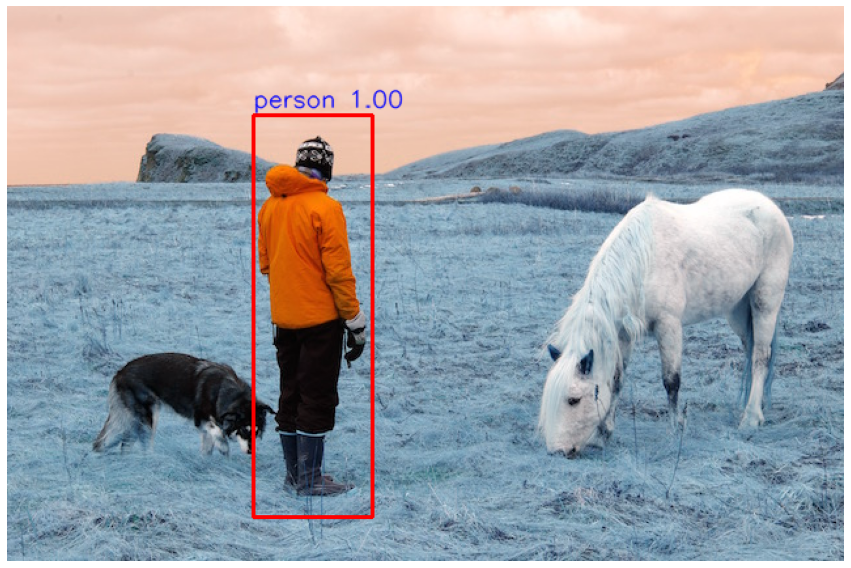

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(image)
plt.show()

In [64]:
f = 'img4.jpg'
path = 'images/'+f
image = cv2.imread(path)
image = detect_image(image, yolo, all_classes)
cv2.imwrite('images/res/' + f, image)

time: 1.51s
class: person, score: 1.00
box coordinate x,y,w,h: [ 228.19827199   31.87151921 1139.0139699   923.32622087]
class: cell phone, score: 1.00
box coordinate x,y,w,h: [677.89151669 405.79327387 413.53416443 204.17370491]



True

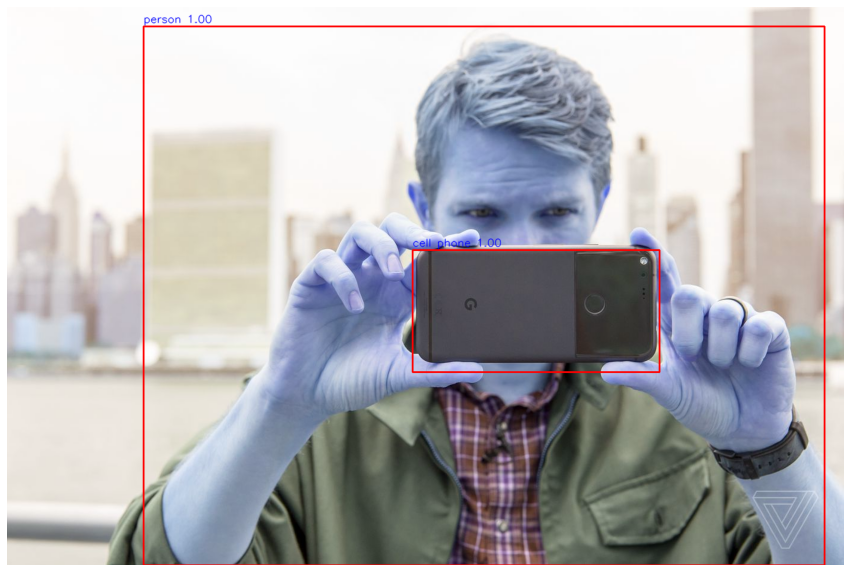

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(image)
plt.show()

# Detecting on Video

In [66]:
# # detect videos one at a time in videos/test folder    
# video = 'library1.mp4'
# detect_video(video, yolo, all_classes)